# Bayesian Chebyshev regression

Author: Wouter Kouw. Last update: 21-feb-2022

The Chebyshev polynomials $T_n(x)$ are polynomials with the largest possible leading coefficient, whose absolute value on the interval [−1, 1] is bounded by 1. They form an orthonormal basis. A function defined on the domain $-1 \leq x \leq 1$ can be expressed by the series:

$$ f(x) = \sum_{n=0}^{\infty} \alpha_n T_n(x) \, .$$

A finite approximation is a Chebyshev series. We can utilize this in a regression problem from $x$ to $y$:

$$y_k = \theta^{\top} T_n(x_k) + e_k \, ,$$

where $e_k \sim \mathcal{N}(0, \tau^{-1})$ with precision $\tau$.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
IJulia.clear_output();

In [2]:
using LinearAlgebra
using LaTeXStrings
using Distributions
using ReactiveMP
using Polynomials
using Plots
default(grid=false, label="", size=(800,400), lw=3, margin=10Plots.pt, labelfontsize=12, legendfontsize=12)

## Data

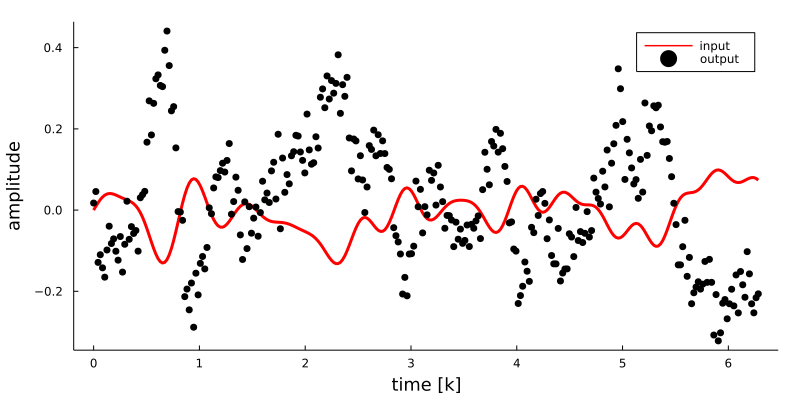

In [3]:
# Sample size
N = 300

# Noise standard dev
σ = 5e-2

# Input signal
Ω = randn(100)
xx = range(0, stop=2π, length=N)
x = [mean(sin.(2π*Ω*x)) for x in xx]

# Output signal
f(u) = tanh(-u*3)*cos(3*u)
y = f.(x) + σ*randn(N)

# Plot signals
plot(xx, x, label="input", color="red", xlabel="time [k]", ylabel="amplitude")
scatter!(xx, y, label="output", color="black")

## Model

In [4]:
# Polynomial order
D = 4;

In [10]:
function Vandermonde(x; D=0)
    V = zeros(D+1)
    for d in 1:D+1
        w = zeros(D+1)
        w[d] = 1
        p = ChebyshevT(w)
        V[d] = p(x)
    end
    return V
end

# Generate basis expansion
ϕ = Vandermonde.(x,D=D)

300-element Vector{Vector{Float64}}:
 [1.0, 0.0, -1.0, 0.0, 1.0]
 [1.0, 0.00931138290764062, -0.9998265962966946, -0.027930919466363703, 0.999306445324467]
 [1.0, 0.01807318873963262, -0.9993467196975633, -0.05419595250248621, 0.99738773234056]
 [1.0, 0.025792857109449504, -0.998669457044263, -0.07730993431967789, 0.9946813688661662]
 [1.0, 0.032084789385372486, -0.9979411325801926, -0.09612225150104362, 0.991773008190875]
 [1.0, 0.03670702657201057, -0.9973051884004834, -0.10992324267405167, 0.9892352776210475]
 [1.0, 0.0395801095243523, -0.9968668298600806, -0.11849230613846401, 0.9874869529505736]
 [1.0, 0.04078578406132219, -0.9966730396370064, -0.1220859668100753, 0.9867142958785394]
 [1.0, 0.040545724037764276, -0.9967120885245069, -0.12137055061060095, 0.9868699748217691]
 [1.0, 0.03918294629407257, -0.9969293934394317, -0.11730820805831174, 0.9877364310070262]
 [1.0, 0.037070776367196676, -0.9972515150790666, -0.11100855216188496, 0.9890211686549875]
 [1.0, 0.034575824647997286

In [11]:
# Recognition factor parameters
ξ = zeros(D+1,N)
Λ = zeros(D+1,D+1,N)
α = zeros(N)
β = zeros(N)

# Prior parameters of coefficients
ξ[:,1] = zeros(D+1)
Λ[:,:,1] = diagm(ones(D+1))

# Prior parameters of precision
α[1] = 1e0
β[1] = 1e-2;

for k in 2:N
    
    # Current recognition factors
    ξ_k = ξ[:,k-1]
    Λ_k = Λ[:,:,k-1]
    α_k = α[k-1]
    β_k = β[k-1]
    
    for _ in 1:10
    
        # Update coefficients
        ξ_k = ξ[:,k-1] + α_k/β_k*y[k]*ϕ[k]
        Λ_k = Λ[:,:,k-1] + α_k/β_k*ϕ[k]*ϕ[k]'
        μ_k = inv(Λ_k)*ξ_k
        
        # Update precision
        α_k = α[k-1] + 1/2
        β_k = β[k-1] + 1/2((y[k] - μ_k'*ϕ[k])^2 + ϕ[k]'*inv(Λ_k)*ϕ[k])
        
    end
    
    # Update bookkeeping
    ξ[:,k] = ξ_k
    Λ[:,:,k] = Λ_k
    α[k] = α_k
    β[k] = β_k
end

In [12]:
# Map estimate of final marginal
μ_star = inv(Λ[:,:,end])*ξ[:,end]

# Predictions
y_hat = μ_star'*hcat(ϕ...)

1×300 adjoint(::Vector{Float64}) with eltype Float64:
 0.00547249  -0.00726057  -0.0192078  …  -0.102147  -0.0995044  -0.0940842

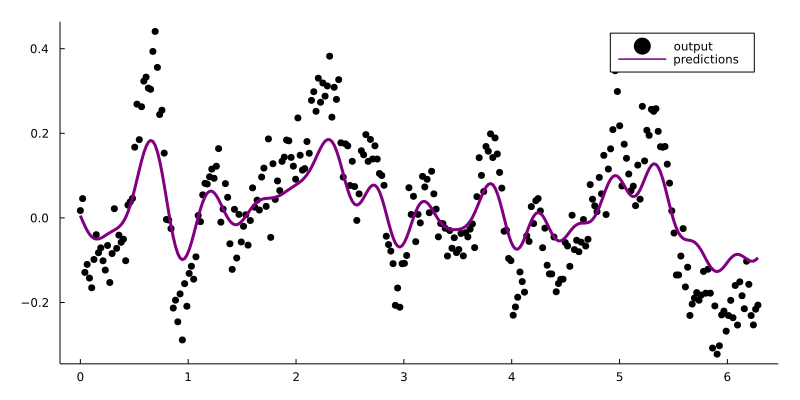

In [13]:
# Plot signals
scatter(xx, y, label="output", lw=3, color="black")
plot!(xx, y_hat', label="predictions", color="purple")

In [14]:
savefig("figures/Chebyshev-regression_training-fit.png")